In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import requests
import math
import warnings
from scipy.stats import chi2_contingency
import copy

### Settings (Edit Each Run)

In [6]:
# cancerTypeDetailed or cancerType or oncotreeLevel2
analysis_type = 'cancerType'
# Set to true if you have 
use_facets = False
# Path to the config file you are using
config = "/home/sumans/Projects/Project_BoundlessBio/Production/penguin/global_config_bash_breastfacetsv1.rc"

# matplotlib colors. For ecDNA - amp -, ecDNA - amp +, and ecDNA +. First one is also a general color, we recommend keeping defaults
colors = ["steelblue", "navajowhite", "coral"]

### Get files from config

In [7]:
## Open and read the config file ##

with open(config, 'r') as f :
    bash_script_content = f.read()
    lines = bash_script_content.splitlines()
paths = {}

for line in lines:
    line = line.strip()
    if line and '=' in line:
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        # Handle variable references
        while '${' in value:
            start_index = value.find('${')
            end_index = value.find('}', start_index)
            if start_index != -1 and end_index != -1:
                variable_name = value[start_index + 2:end_index]
                if variable_name in paths:
                    value = value[:start_index] + paths[variable_name] + value[end_index + 1:]
                else:
                    break 
        # Remove surrounding quotes if any
        paths[key] = value.strip('"\'')

In [8]:
print(paths)

{'projectName': 'BREAST_V1_FACETS', 'dataDirectory': '../data', 'inputDirectory': '$(readlink -f "$inputDirectory")', 'manifestDirectory': '../data/input/manifest/BREAST_V1_FACETS', 'outputDirectory': '../data/output/output_BREAST_V1_FACETS', 'logDirectory': '../data/log/log_BREAST_V1_FACETS', 'flagDirectory': '../data/flag/flag_BREAST_V1_FACETS', 'echoOutputDirectory': '../data/output/output_BREAST_V1_FACETS/echoCalls', 'echoLogDirectory': '../data/log/log_BREAST_V1_FACETS/echoCalls', 'echoFlagDirectory': '../data/flag/flag_BREAST_V1_FACETS/echoCalls', 'mergedOutputDirectory': '../data/output/output_BREAST_V1_FACETS/merged', 'sampleFacetsDirectory': '../data/output/output_BREAST_V1_FACETS/sampleFacets', 'facetsOutputDirectory': '../data/output/output_BREAST_V1_FACETS/facetsCalls', 'facetsLogDirectory': '../data/log/log_BREAST_V1_FACETS/facetsCalls', 'facetsFlagDirectory': '../data/flag/flag_BREAST_V1_FACETS/facetsCalls', 'sampleFull': '../data/input/manifest/BREAST_V1_FACETS/FileB.tsv

In [10]:
## Get paths and open using pandas ##

# Merged ECHO results
echo = pd.read_csv(paths['mergedOutputDirectory'] + '/merged.ECHO_results.csv')
# Merged FACETS cbioportal file
manifest = pd.read_csv(paths['manifestDirectory'] + '/FileA.tsv', sep = '\t')
# Merged FACETS results
if use_facets :
    facets = pd.read_csv(paths['mergedOutputDirectory'] + '/merged.FACETS_gene_results.tsv', sep = '\t')

### Clean Up and Prepare Dataframes

In [11]:
## set up oncotree codes via API ##

# Get api 
url = 'https://oncotree.mskcc.org/api/tumorTypes/tree'
headers = {'Accept': 'application/json'}
response = requests.get(url, headers=headers)

# Read tree into dictionary
def parse_tree(data):
    if not isinstance(data, dict):
        return data
    
    parsed_data = {}
    for key, value in data.items():
        if isinstance(value, dict):
            parsed_data[key] = parse_tree(value)
        elif isinstance(value, list):
            parsed_data[key] = [parse_tree(item) for item in value]
        else:
            parsed_data[key] = value
    
    return parsed_data

parsed_data = parse_tree(response.json())

# dictionary that matches the oncotree code to the name of the cancer (second tier)
oncotree_dict = {}

def dfs_oncotree(node):
    codes = [node['code']]
    # Recursively traverse children
    for child in node['children'] :
        codes.extend(dfs_oncotree(node['children'][child]))
    return codes

for tissue in parsed_data['TISSUE']['children'] :
    for specific in parsed_data['TISSUE']['children'][tissue]['children'] :
        oncotree_dict[parsed_data['TISSUE']['children'][tissue]['children'][specific]['name']] = set(dfs_oncotree(parsed_data['TISSUE']['children'][tissue]['children'][specific]))


In [12]:
## Set up gene level dataframe ##

echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

# merge manifest annotations into echo
manifest = manifest[['sampleId', 'cancerType', 'cancerTypeDetailed', 'oncotreeCode', 'msiScore', 'msiType', 'mutationCount', 'fractionAltered', 'deIDAge', 'stageHighest', 'sampleType', 'tumorBurdenScore']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')

# Fill oncotree codes
echo['oncotreeLevel2'] = ""
for i, row in echo.iterrows() :
    for key in oncotree_dict :
        if row['oncotreeCode'] in oncotree_dict[key] :
            echo.loc[i, 'oncotreeLevel2'] = key

In [13]:
## Add facets annotations to sample level dataframe if available ##

if use_facets :

    # Match the facets copy number and amplification status from sample + gene
    facets_cn_dict = {}
    facets_amp_dict = {}
    
    for i, row in facets.iterrows() :
        if row['gene'] != 'No_genes_above_ECHO_amplification_threshold' :
            to_hash = row['sample'] + '_' + row['gene']
            facets_cn_dict[to_hash] = float(row['tcn'])
            facets_amp_dict[to_hash] = row['cn_state']

    # add data to sample level dataframe
    echo['facets_cn'] = np.nan
    echo['facets_amp'] = ''
    echo['facets_amp_binary'] = "No Amp"
    
    for i, row in echo.iterrows() :
        if isinstance(row['gene'], str) :
            to_hash = row['tumorSampleId'] + '_' + row['gene']
            if to_hash in facets_cn_dict :
                echo.loc[i, 'facets_cn'] = facets_cn_dict[to_hash]
            if to_hash in facets_amp_dict :
                echo.loc[i, 'facets_amp'] = facets_amp_dict[to_hash]
                if isinstance(facets_amp_dict[to_hash], str) :
                    if "AMP" in facets_amp_dict[to_hash] or "GAIN" in facets_amp_dict[to_hash] :
                        echo.loc[i, 'facets_amp_binary'] = "Amp"

In [14]:
## Create patient level dictionary ##

# This tracks all genes with ecDNA, separated by _
ecDNA_per_patient = {}
for idx, row in echo.iterrows() :
    if row['patientId'] not in ecDNA_per_patient :
        ecDNA_per_patient[row['patientId']] = ''
    if row['ecDNA_status'] == 'ecDNA' :
        if ecDNA_per_patient[row['patientId']] == '' :
            ecDNA_per_patient[row['patientId']] = row['gene']
        else :
            ecDNA_per_patient[row['patientId']] += '_' + row['gene']

# All unique patients
patientsList = echo['patientId'].unique()

# Tracks ecDNA status of each patient using above dataframe
ecDNA_patient = pd.DataFrame(patientsList, columns = ['patientId'])
ecDNA_patient['ecDNAStatus'] = None
ecDNA_patient['ecDNAList'] = ''

for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient.loc[idx, 'ecDNAList'] = ecDNA_per_patient[row['patientId']]
    if ecDNA_per_patient[row['patientId']] == '' :
        ecDNA_patient.loc[idx, 'ecDNAStatus'] = False
    else :
        ecDNA_patient.loc[idx, 'ecDNAStatus'] = True


### Basic Plots

Text(0, 0.5, 'No. Samples')

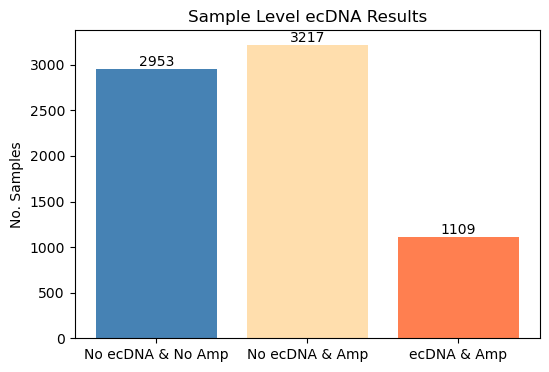

In [15]:
## Sample level ecDNA general plot ##

# Fill in bars
num_total_samples = len(echo['tumorSampleId'].unique())
num_ecdna = len(echo[echo['ecDNA_status'] == 'ecDNA']['tumorSampleId'].unique())
num_no_amp = len(echo[echo['ecDNA_status'] == 'No genes above ECHO amplification threshold']['tumorSampleId'].unique()) 
num_amp = num_total_samples - num_ecdna - num_no_amp
bar_labels = ['No ecDNA & No Amp', 'No ecDNA & Amp', 'ecDNA & Amp']
bar_values = [num_no_amp, num_amp, num_ecdna]

# Plot!
plt.figure(figsize=(6, 4))
bars = plt.bar(bar_labels, bar_values,color=colors)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.title("Sample Level ecDNA Results")
plt.ylabel("No. Samples")

Text(0, 0.5, 'No. Samples')

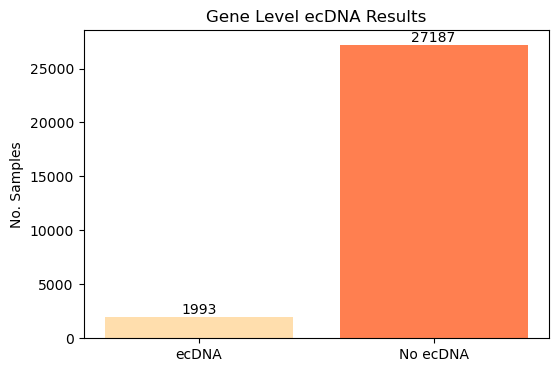

In [16]:
## gene level ecDNA general plot ##

# Fill in bars
num_total_samples = len(echo['tumorSampleId'].unique())
num_ecdna = len(echo[echo['ecDNA_status'] == 'ecDNA']['tumorSampleId'].unique())
num_no_amp = len(echo[echo['ecDNA_status'] == 'No genes above ECHO amplification threshold']['tumorSampleId'].unique()) 
num_amp = num_total_samples - num_ecdna - num_no_amp
bar_labels = ['ecDNA', 'No ecDNA']
bar_values = [len(echo[echo['ecDNA_status'] == 'ecDNA']), len(echo[echo['ecDNA_status'] == 'non-ecDNA'])]

# Plot!
plt.figure(figsize=(6, 4))
bars = plt.bar(bar_labels, bar_values,color=colors[1:3])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.title("Gene Level ecDNA Results")
plt.ylabel("No. Samples")

In [17]:
## Compare facets and echo copy numbers ##

if use_facets :
    plt.figure(figsize=(8, 6))
    plt.scatter(echo['cn'], echo['facets_cn'], alpha = 0.4, color = colors[0])

    # Log scale used
    plt.yscale('log')
    plt.xscale('log')
    
    plt.title("FACETS vs ECHO Copy Number")
    plt.xlabel('ECHO cn')
    plt.ylabel('FACETS cn')   
    
    # Add a line at y = x
    x_values = np.arange(max(echo['cn'].min(), echo['facets_cn'].min()), max(echo['cn'].max(), echo['facets_cn'].max()))
    plt.plot(x_values, x_values, color = colors[2], linestyle = '--', label = 'y=x', alpha = 0.8)

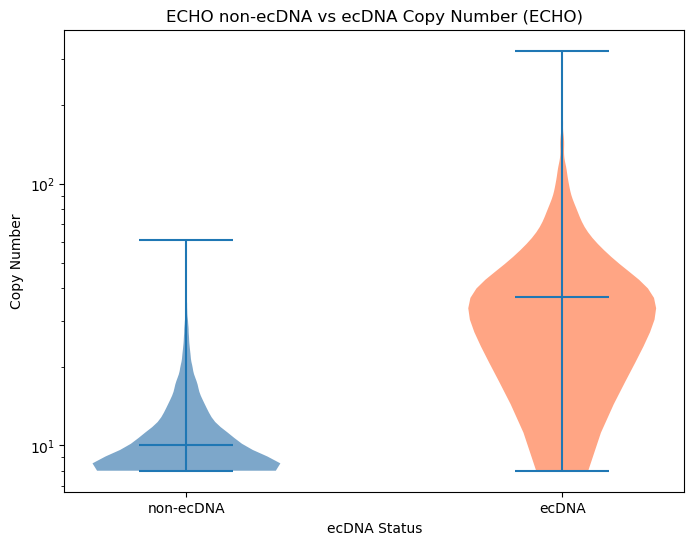

In [18]:
## Copy number of ecDNA + vs - ##

plt.figure(figsize=(8, 6))
violin = plt.violinplot(dataset=[echo[echo['ecDNA_status'] == 'non-ecDNA']['cn'], 
                        echo[echo['ecDNA_status'] == 'ecDNA']['cn']],
               showmeans=False, showmedians=True)

# Add matching colors (:
for i, pc in enumerate(violin['bodies']):
    if i == 1 :
        i = 2
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
    
plt.title('ECHO non-ecDNA vs ecDNA Copy Number (ECHO)')
plt.xticks([1, 2], ['non-ecDNA', 'ecDNA']) 
plt.ylabel('Copy Number')
plt.xlabel("ecDNA Status")
plt.yscale('log')
plt.show()

In [19]:
## FACETS version copy number plot ##

if use_facets :
    plt.figure(figsize=(8, 6))
    violin = plt.violinplot(dataset=[echo.loc[(echo['ecDNA_status'] != 'ecDNA') & (~echo['facets_cn'].isna()), 'facets_cn'], 
                            echo.loc[(echo['ecDNA_status'] == 'ecDNA') & (~echo['facets_cn'].isna()), 'facets_cn']],
                   showmeans=False, showmedians=True)

    # Add matching colors (:
    for i, pc in enumerate(violin['bodies']):
        if i == 1 :
            i = 2
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
        
    plt.title('ECHO non-ecDNA vs ecDNA Copy Number (FACETS)')
    plt.xticks([1, 2], ['non-ecDNA', 'ecDNA']) 
    plt.ylabel('Copy Number')
    plt.xlabel("ecDNA Status")
    plt.yscale('log')
    plt.show()

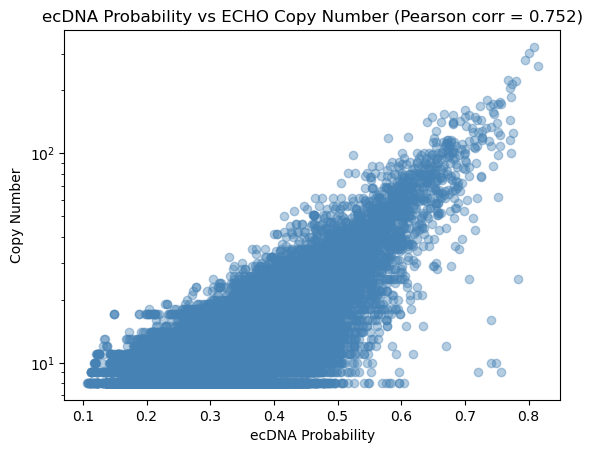

In [20]:
## ecDNA probability vs copy number ##

plt.scatter(echo['ecDNA_prob'], echo['cn'], alpha=0.4, color = colors[0])
plt.ylabel("Copy Number")
plt.xlabel("ecDNA Probability")
plt.yscale('log')

# Calculate correlation (using log)
echo['cn_log'] = echo['cn']
for i, row in echo.iterrows() :
    echo.loc[i, 'cn_log'] = math.log10(row['cn'])
    
corr_matrix = echo[['ecDNA_prob', 'cn_log']].corr(method='pearson')
pearson_corr_log = corr_matrix.loc['ecDNA_prob', 'cn_log']

plt.title(f"ecDNA Probability vs ECHO Copy Number (Pearson corr = {'%.3f'%pearson_corr_log})")
plt.show()

In [21]:
## FACETS copy number vs ecDNA probability ##

if use_facets :
    # Calculate correlation (using log)
    echo['facets_cn_log'] = echo['facets_cn']
    for i, row in echo.iterrows() :
        echo.loc[i, 'cn_log'] = math.log10(row['cn'])
        
    corr_matrix = echo[['ecDNA_prob', 'facets_cn_log']].corr(method='pearson')
    pearson_corr_log = corr_matrix.loc['ecDNA_prob', 'facets_cn_log']
    
    plt.figure(figsize=(8, 6))
    plt.scatter(echo['ecDNA_prob'], echo['facets_cn'], alpha=0.4, color = colors[0])
    plt.ylabel("Copy Number")
    plt.xlabel("ecDNA Probability")
    plt.yscale('log')
    plt.title(f"ecDNA Probability vs FACETS Copy Number (Pearson corr = {'%.3f'%pearson_corr_log})")

### Landscape Plots

In [22]:
## Set up patient wise dataframe ##

# Add in info from cbioportal
ecDNA_patient['vitalStatus'] = 'NA'
ecDNA_patient['cancerType'] = 'NA'
ecDNA_patient['cancerTypeDetailed'] = 'NA'
ecDNA_patient['oncotreeLevel2'] = 'NA'
ecDNA_patient['oncogeneAmp'] = "No Amp"
if use_facets :
    ecDNA_patient['facetsAmp'] = "No Amp"
ecDNA_patient['deIDAge'] = 'NA'

# Matches patientIds to indexes
ecDNA_patient_indexes = {}
for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient_indexes[row['patientId']] = idx

# Now the info is right from echo results!
for idx, row in echo.iterrows() :
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'cancerType'] = row['cancerType']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'cancerTypeDetailed'] = row['cancerTypeDetailed']
    
    if use_facets :
        ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'facetsAmp'] = row['facets_amp_binary']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'deIDAge'] = row['deIDAge']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'oncotreeLevel2'] = row['oncotreeLevel2']

    if not math.isnan(row['ecDNA_prob']) :
        ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'oncogeneAmp'] = "Amp"

# Create combined status
ecDNA_patient['ecDNAStatusStr'] = ecDNA_patient['ecDNAStatus'].replace({True: 'ecDNA', False: 'non-ecDNA'})
ecDNA_patient['combined_status'] = ecDNA_patient['ecDNAStatusStr'] + " & " + ecDNA_patient['oncogeneAmp']

if use_facets :
    ecDNA_patient['facets_combined_status'] = ecDNA_patient['ecDNAStatusStr'] + " & " + ecDNA_patient['facetsAmp']


In [23]:
## Create echo amplification crosstab ##

# Incorporate more items when facets is turned on
if use_facets :
    ecDNA_patient_binary = ecDNA_patient[['vitalStatus', 'ecDNAStatus', analysis_type, 'oncogeneAmp', 'facetsAmp']].astype(str)
else :
    ecDNA_patient_binary = ecDNA_patient[['vitalStatus', 'ecDNAStatus', analysis_type, 'oncogeneAmp']].astype(str)

ecDNA_patient_binary_filtered = ecDNA_patient_binary.dropna(subset=[analysis_type])
ecDNA_patient_binary_filtered = ecDNA_patient_binary[ecDNA_patient_binary[analysis_type] != 'nan']

crosstab = pd.crosstab(ecDNA_patient_binary_filtered['oncogeneAmp'], ecDNA_patient_binary_filtered['ecDNAStatus'])
print("Using ECHO Amplification")
crosstab

Using ECHO Amplification


ecDNAStatus,False,True
oncogeneAmp,,
Amp,2737,989
No Amp,2450,0


In [24]:
## Facets version 
if use_facets :
    crosstab = pd.crosstab(ecDNA_patient_binary_filtered['facetsAmp'], ecDNA_patient_binary_filtered['ecDNAStatus'])
    print("Using FACETS Amplification")
    print(crosstab)

In [25]:
## Set up landscape ##

# Ignore all warnings
warnings.filterwarnings('ignore')

# Change the labels from true/false to ecDNA status
ecDNA_patient_binary_filtered['ecDNAStatus'] = ecDNA_patient_binary_filtered['ecDNAStatus'].replace({'True': 'ecDNA', 'False': 'non-ecDNA'})
ecDNA_patient_binary_filtered['Status'] = ecDNA_patient_binary_filtered['ecDNAStatus'] + " & " + ecDNA_patient_binary_filtered['oncogeneAmp']

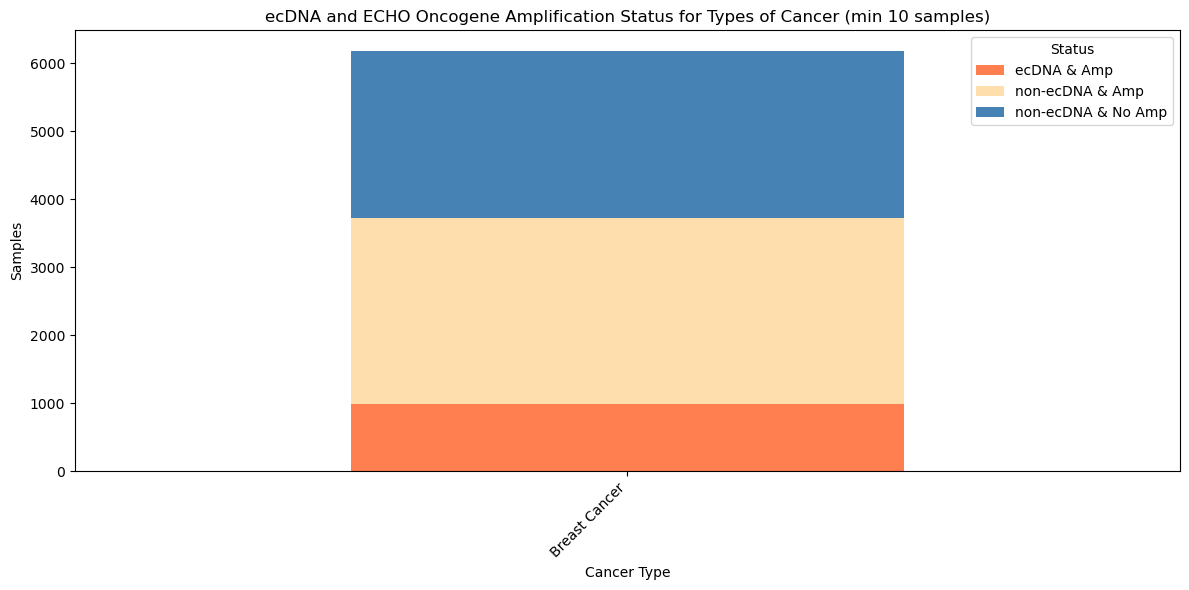

In [26]:
## Landscape non-normalized (ECHO amp) ##

crosstab_cancerType = pd.crosstab(ecDNA_patient_binary_filtered[analysis_type], ecDNA_patient_binary_filtered['Status'])
crosstab_cancerType = crosstab_cancerType.loc[crosstab_cancerType.sum(axis = 1) >= 10]
crosstab_cancerType = crosstab_cancerType.sort_values(by = 'ecDNA & Amp', ascending = False)
crosstab_cancerType.plot(kind = 'bar', stacked = True, color = [colors[2], colors[1], colors[0]], figsize = (12, 6))
plt.ylabel("Samples")
plt.xlabel("Cancer Type")
plt.title("ecDNA and ECHO Oncogene Amplification Status for Types of Cancer (min 10 samples)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

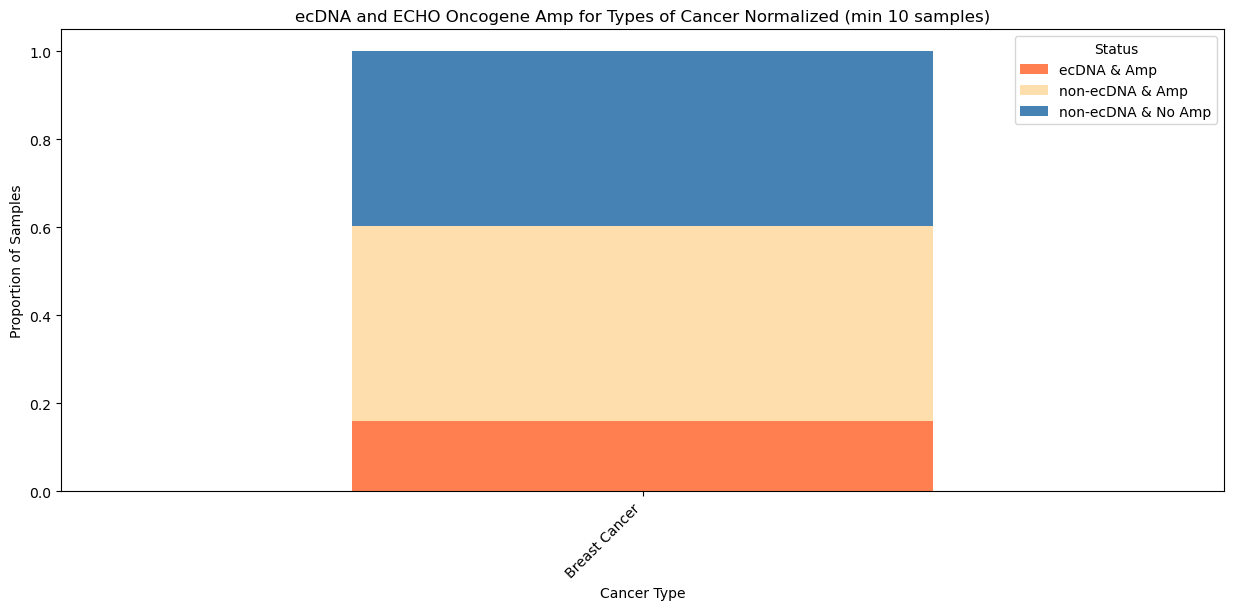

In [27]:
## Normalized landscape ##

normalized_crosstab_cancerType = crosstab_cancerType.div(crosstab_cancerType.sum(axis = 1), axis = 0)
normalized_crosstab_cancerType = normalized_crosstab_cancerType.sort_values(by = 'ecDNA & Amp', ascending = False)
normalized_crosstab_cancerType.plot(kind = 'bar', stacked = True, color = [colors[2], colors[1], colors[0]], figsize=(15,6))
plt.ylabel("Proportion of Samples")
plt.xlabel("Cancer Type")
plt.title("ecDNA and ECHO Oncogene Amp for Types of Cancer Normalized (min 10 samples)")
plt.xticks(rotation=45, ha='right')
plt.show()

### Gene Level

In [28]:
## Count the number of times each gene is called ecDNA and non-ecDNA ##

# The data will be stored in these dicts
gene_called_nonecDNA_count = {}
gene_ecDNA_count = {}

for idx, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if row['gene'] in gene_ecDNA_count :
            gene_ecDNA_count[row['gene']] += 1
        else :
            gene_ecDNA_count[row['gene']] = 1
        # Need this to be set at 0 at least so it does not mess up the graph
        if not row['gene'] in gene_called_nonecDNA_count :
            gene_called_nonecDNA_count[row['gene']] = 0
            
    elif row['ecDNA_status'] == 'non-ecDNA' :
        if row['gene'] in gene_called_nonecDNA_count :
            gene_called_nonecDNA_count[row['gene']] += 1
        else :
            gene_called_nonecDNA_count[row['gene']] = 1




In [29]:
## Get the list of genes for each IMPACT panel ##

# These should be in the notebook directory
im3 = pd.read_excel("./IMPACT341-Gene-List_20140101.xlsx")
im3_genes = set(im3['Gene_Symbol'].unique())

im5 = pd.read_excel("./IMPACT410-Gene-List_20150201.xlsx")
im5_genes = set(im5['Gene_Symbol'].unique())

im6 = pd.read_excel("./impact-genes-468.xlsx")
im6_genes = set(im6['Approved Symbol'].unique())

im7 = pd.read_excel("./IMPACT505_Gene_list_detailed.xlsx", header = None)
im7_genes = set()
for column in im7.columns:
    im7_genes.update(im7[column].unique())
im7_genes.remove(np.nan)

In [30]:
## Count the number of samples in each IMPACT panel ##

number_im3, number_im5, number_im6, number_im7 = 0, 0, 0, 0

for sample in echo['sampleId'].unique() :
    try :
        if sample[-3:] == "IM3" :
            number_im3 += 1
        elif sample[-3:] == "IM5" :
            number_im5 += 1
        elif sample[-3:] == "IM6" :
            number_im6 += 1
        elif sample[-3:] == "IM7" :
            number_im7 += 1
    except :
        print(f"Warning: {sample} panel not found.")

print(f"IM3: {number_im3}")
print(f"IM5: {number_im5}")
print(f"IM6: {number_im6}")
print(f"IM7: {number_im7}")

IM3: 343
IM5: 915
IM6: 3975
IM7: 2046


In [31]:
## Get the number of times each gene is called ##

gene_ecDNA_percentages = {}

def change_gene(gene) :
    new_gene = gene
    # These have alternate names that are used
    conversion_dict = {"NSD3" : "WHSC1L1", "ELOC" : "TCEB1", "H2BC5" : "HIST1H2BD", "ABRAXAS1" : "FAM175A", "MYCL" : "MYCL1", "H3-3B" : "H3F3B", "H3C6" : "HIST1H3E", "H1-2" : "HIST1H1C", "PRKN" : "PARK2"}
    if new_gene in conversion_dict :
        new_gene = conversion_dict[new_gene]
    # Results should be in list form since RAD51D has differences
    new_gene = [new_gene]
    if "RAD51D" in new_gene :
        new_gene.append("RAD51L3")

    return new_gene

for gene in gene_ecDNA_count :
    new_genes = change_gene(gene)    
    # Tally number for each gene
    total_num = 0
    
    for new_gene in new_genes :
        if new_gene in im3_genes :
            total_num += number_im3
        if new_gene in im5_genes :
            total_num += number_im5
        if new_gene in im6_genes :
            total_num += number_im6
        if new_gene in im7_genes :
            total_num += number_im7

    # Default to max number
    if total_num < 3 :
        print(f"{gene} Not Found. Using {len(echo['tumorSampleId'].unique())}")
        total_num = len(echo['tumorSampleId'].unique())
    gene_ecDNA_percentages[gene] = gene_ecDNA_count[gene]/total_num


CD44 Not Found. Using 7279
IKZF3 Not Found. Using 7279
EWSR1 Not Found. Using 7279
STAT6 Not Found. Using 7279
PAX8 Not Found. Using 7279
TFE3 Not Found. Using 7279
NRG1 Not Found. Using 7279
COP1 Not Found. Using 7279
RELN Not Found. Using 7279


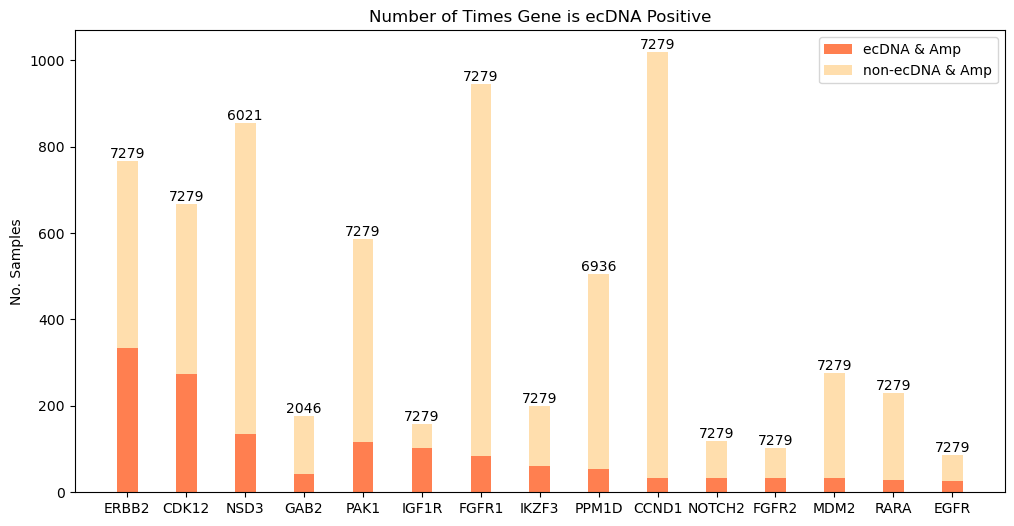

In [32]:
## Most ecDNA + genes from all genes ##

# Pick out top 15 from sorted proportion of ecDNA positive
gene_ecDNA_top15 = dict(sorted(gene_ecDNA_percentages.items(), key=lambda x: x[1], reverse=True)[:15])

# Get data for top 15
keys = gene_ecDNA_top15.keys()
ecDNA_neg = [gene_called_nonecDNA_count[key] for key in keys]
ecDNA_pos = [gene_ecDNA_count[key] for key in keys]

ind = np.arange(len(keys))
width = 0.35

plt.figure(figsize = (12, 6))
p1 = plt.bar(ind, ecDNA_pos, width, color = colors[2])
p2 = plt.bar(ind, ecDNA_neg, width, bottom=ecDNA_pos, color = colors[1])

# Add labels for number of times the gene is sequenced
for i, value in enumerate(gene_ecDNA_top15) :
    # Change gene names
    values = change_gene(value)

    # Put labels for each which are the number of samples the gene was queried in
    total_num = 0
    for value in values :
        if value in im3_genes :
            total_num += number_im3
        if value in im5_genes :
            total_num += number_im5
        if value in im6_genes :
            total_num += number_im6
        if value in im7_genes :
            total_num += number_im7
        if total_num < 3 :
            total_num = len(echo['tumorSampleId'].unique())
    plt.text(i, ecDNA_neg[i] + ecDNA_pos[i], str(total_num), ha = 'center', va = 'bottom')

plt.ylabel('No. Samples')
plt.title('Number of Times Gene is ecDNA Positive')
plt.xticks(ind, keys)
plt.legend(('ecDNA & Amp', 'non-ecDNA & Amp'))

plt.show()

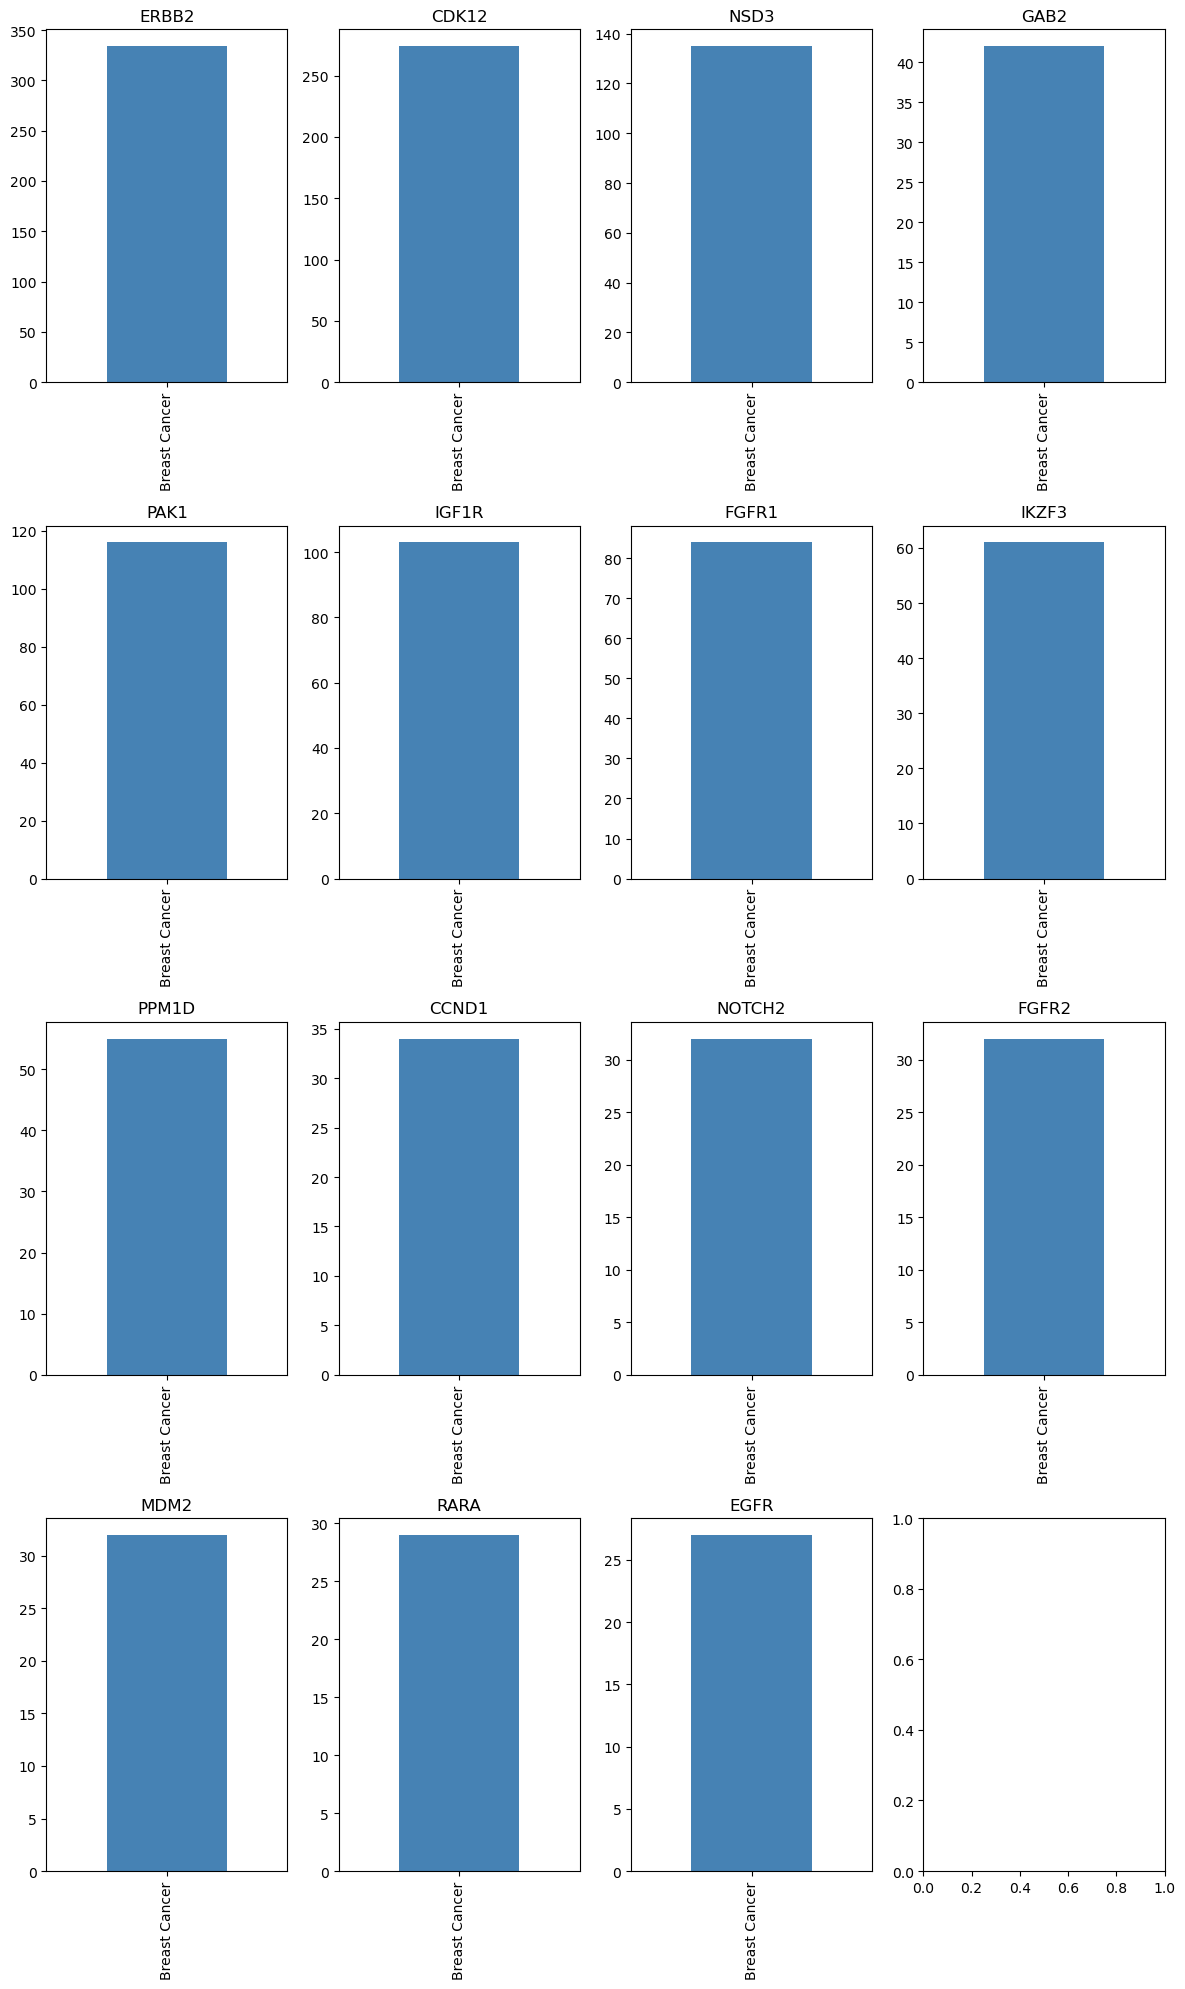

In [33]:
## Distribution of which cancers these genes are found in ##

fig, axs = plt.subplots((len(gene_ecDNA_top15)+3)//4, 4, figsize = (12, 2 + 1.2 * len(gene_ecDNA_top15)))
axs = axs.flatten()

for i, gene in enumerate(gene_ecDNA_top15) :
        subset = echo[echo['gene'] == gene]
        subset = subset[subset['ecDNA_status'] == 'ecDNA']
        
        counts = subset[analysis_type].value_counts()
        counts.plot(kind = 'bar', ax = axs[i], color = colors[0])
        axs[i].set_title(gene)
        axs[i].set_xlabel('')
fig.tight_layout()



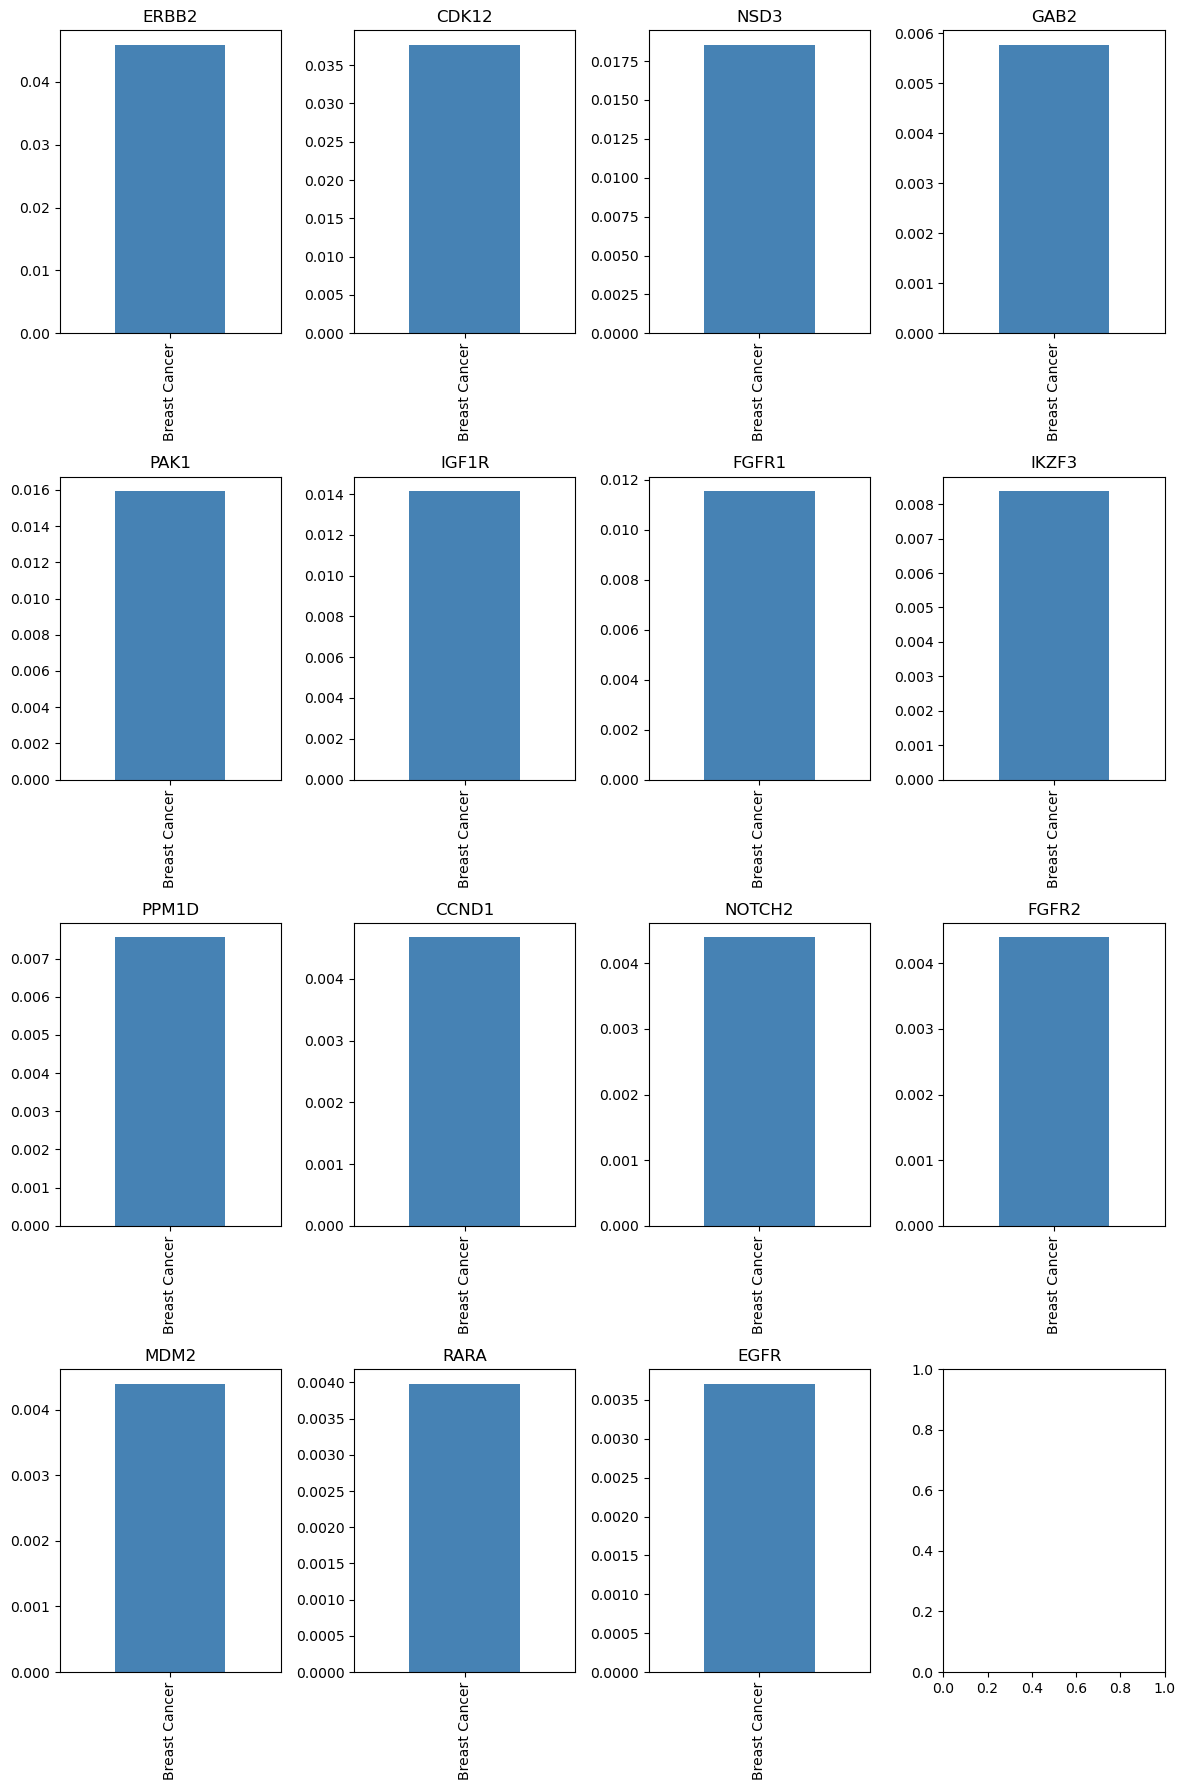

In [34]:
## Normalizing for the number of patients from each cancer type ##

cancerCounts = {}
# Create a list of valid cancer types
cancerTypes = echo[analysis_type].unique()
cancerTypes = [item for item in cancerTypes if item != '']
cancerTypes = [item for item in cancerTypes if item != 'NA']

for ctype in cancerTypes :
    cancerCounts[ctype] = len(echo[echo[analysis_type] == ctype]['tumorSampleId'].unique())
        
fig, axs = plt.subplots((len(gene_ecDNA_top15)+3)//4, 4, figsize = (12, 1.2 * len(gene_ecDNA_top15)))
axs = axs.flatten()

for i, gene in enumerate(gene_ecDNA_top15) :
        subset = echo[echo['gene'] == gene]
        subset = subset[subset['ecDNA_status'] == 'ecDNA']
        
        counts = subset[analysis_type].value_counts()
        counts = counts / counts.index.map(cancerCounts)
        counts.plot(kind = 'bar', ax = axs[i], color = colors[0])
        axs[i].set_title(gene)
        axs[i].set_xlabel('')
fig.tight_layout()


In [35]:
## Create dictionaries describing ecDNA + and Amp + for each cancer type ##

# Dictionaries of ecDNA positive by cancer type
ctype_dicts = []

# Dictionaries of ecDNA negative amp positive by cancer type
ctype_non_dicts = []

# List of cancers to analyze
cancers_with_ecDNA = []

for ctype in cancerTypes :
    ctype_dict = {}
    ctype_non_dict = {}
    for i, row in echo.iterrows() :
        if row[analysis_type] == ctype :
            if row['ecDNA_status'] == 'ecDNA' :
                if isinstance(row['gene'], str) :
                    if not row['gene'] in ctype_dict :
                        ctype_dict[row['gene']] = 1
                    else :
                        ctype_dict[row['gene']] += 1
            if row['ecDNA_status'] == 'non-ecDNA' :
                if isinstance(row['gene'], str) :
                    if not row['gene'] in ctype_non_dict :
                        ctype_non_dict[row['gene']] = 1
                    else :
                        ctype_non_dict[row['gene']] += 1

    # Only add if we find any ecDNA
    if len(ctype_dict) > 0 :
        ctype_dicts.append(ctype_dict)
        ctype_non_dicts.append(ctype_non_dict)
        cancers_with_ecDNA.append(ctype)

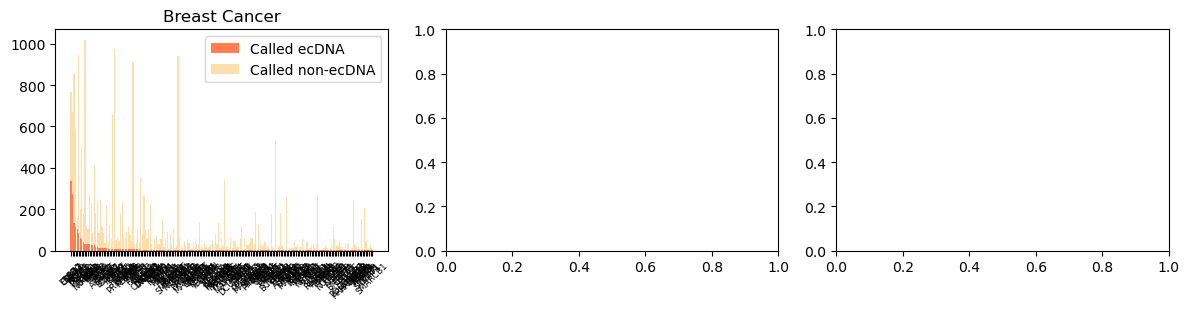

In [36]:
## Plot ecDNA genes by cancer type ##

fig, axs = plt.subplots((len(cancers_with_ecDNA)+2)//3, 3, figsize = (12, 2 + 1.2 * len(cancers_with_ecDNA)))
axs = axs.flatten()

for i, ctype in enumerate(cancers_with_ecDNA) :
    labels = list(ctype_dicts[i].keys())
    values_dict1 = [ctype_dicts[i].get(label, 0) for label in labels]
    values_dict2 = [ctype_non_dicts[i].get(label, 0) for label in labels]

    # Combine the lists into a list of tuples
    combined = list(zip(values_dict1, values_dict2, labels))
    
    # Sort the combined list by the first element (elements of list1)
    sorted_combined = sorted(combined, key=lambda x: x[0], reverse = True)
    
    # Unzip the sorted list back into individual lists
    values_dict1, values_dict2, labels = zip(*sorted_combined)

    axs[i].bar(labels, values_dict1, color = colors[2])
    axs[i].bar(labels, values_dict2, bottom = values_dict1, color = colors[1])
    axs[i].set_title(ctype)
    axs[i].set_xticklabels(labels, rotation=45, fontsize=6)
    axs[i].set_xlabel('')
    axs[i].legend(('Called ecDNA', 'Called non-ecDNA'))

fig.tight_layout()

### Segment Size from FACETS Results

In [37]:
## Create a dicionary that matches sampleId + gene (key) to FACETS cn (value) ##

if use_facets :
    facets_seq_length = facets.dropna(subset = ['seg_length'])
    
    # Build a dictionary for ecDNA
    ecDNA_gene_dict = {}
    for i, row in echo.iterrows() :
        if row['ecDNA_status'] == 'ecDNA' :
            to_hash = row['tumorSampleId'] + '_' + row['gene']
            ecDNA_gene_dict[to_hash] = True
    
    # Fill in facets column
    facets_seq_length['ecDNA'] = 'non-ecDNA'
    facets_seq_length['amped'] = False
    
    for i, row in facets_seq_length.iterrows() :
        to_hash = row['sample'] + '_' + row['gene']
        if to_hash in ecDNA_gene_dict :
            facets_seq_length.loc[i, 'ecDNA'] = 'ecDNA'
        if "AMP" in row['cn_state'] or "GAIN" in row['cn_state'] :
            facets_seq_length.loc[i, 'amped'] = True


In [38]:
## Plot copy number vs ecDNA status ##

if use_facets :
    facets_amp = facets_seq_length[facets_seq_length['amped'] == True]
    color_map = {'ecDNA': colors[2], 'non-ecDNA': colors[1]}
    
    # Create a list of colors based on the 'ecDNA' column
    colors_facets = facets_amp['ecDNA'].map(color_map)
    
    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(facets_amp['seg_length'], facets_amp['tcn'], c=colors_facets, label=facets_amp['ecDNA'], alpha = 0.3)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Copy Numnber')
    plt.xlabel('Segment Length')
    plt.title("Copy Number vs Segment Length for FACETS Amplified Genes")
    
    legend_labels = ['ecDNA', 'non-ecDNA']
    legend_colors = [colors[2], colors[1]]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
    plt.legend(markers, legend_labels, loc='upper right')

In [39]:
## Plot distribution for copy number ##

if use_facets :

    # Separate data for ecDNA and non-ecDNA
    ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == 'ecDNA']['tcn']
    log_ecDNA = [math.log10(x) for x in ecDNA_facets_amp]
    
    non_ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == 'non-ecDNA']['tcn']
    log_non_ecDNA = [math.log10(x) for x in non_ecDNA_facets_amp]
    
    # Plotting histograms on logarithmic scale
    plt.figure(figsize=(10, 6))
    bins = np.linspace(min(log_ecDNA + log_non_ecDNA), max(log_ecDNA + log_non_ecDNA),30)
    # Histogram for ecDNA = ecDNA
    plt.hist(log_ecDNA, alpha=0.5, bins = bins, color=colors[2], label='ecDNA', density = True)
    
    # Histogram for ecDNA = non-ecDNA
    plt.hist(log_non_ecDNA,  alpha=0.5, bins = bins, color=colors[1], label='non-ecDNA', density = True)
    
    # Customize the plot
    plt.title('Distribution of Copy Number for FACETS Amplified Genes')
    plt.xlabel('Copy Number (log)')
    plt.ylabel('Proportion')
    
    legend_labels = ['ecDNA', 'non-ecDNA']
    legend_colors = [colors[2], colors[1]]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
    plt.legend(markers, legend_labels, loc='upper right')


In [40]:
## Distribution of segment length ##

if use_facets :
    
    # Separate data for ecDNA and non-ecDNA
    ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == 'ecDNA']['seg_length']
    log_ecDNA = [math.log10(x) for x in ecDNA_facets_amp]
    
    non_ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == 'non-ecDNA']['seg_length']
    log_non_ecDNA = [math.log10(x) for x in non_ecDNA_facets_amp]
    
    # Plotting histograms on logarithmic scale
    plt.figure(figsize=(10, 6))
    bins = np.linspace(min(log_ecDNA + log_non_ecDNA), max(log_ecDNA + log_non_ecDNA),30)
    # Histogram for ecDNA = ecDNA
    plt.hist(log_ecDNA, alpha=0.5, bins = bins, color=colors[2], label='ecDNA', density = True)
    
    # Histogram for ecDNA = non-ecDNA
    plt.hist(log_non_ecDNA,  alpha=0.5, bins = bins, color=colors[1], label='non-ecDNA', density = True)
    
    # Customize the plot
    plt.title('Distribution of Segment Length for FACETS Amplified Genes')
    plt.xlabel('Segment Length (log)')
    plt.ylabel('Proportion')
    
    legend_labels = ['ecDNA', 'non-ecDNA']
    legend_colors = [colors[2], colors[1]]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
    plt.legend(markers, legend_labels, loc='upper right')

### ecDNA Co-occurance + Correlations

Text(0, 0.5, 'No. Samples')

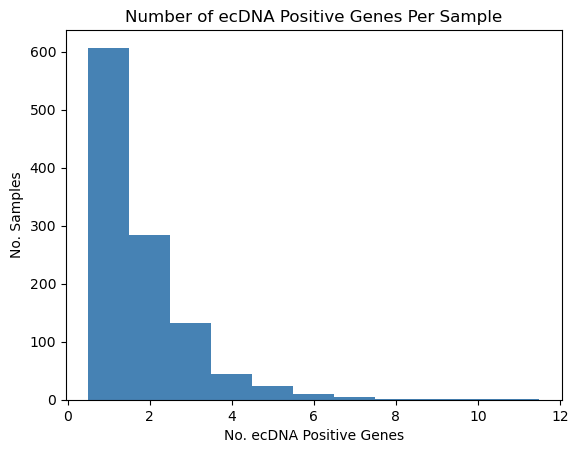

In [41]:
## Plot the distributio of the number of ecDNA positive genes per sample ##

# Dict of ecDNA counts
ecDNA_count_per_patient = {}
for i, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if row['sampleId'] in ecDNA_count_per_patient :
            ecDNA_count_per_patient[row['sampleId']] += 1
        else :
            ecDNA_count_per_patient[row['sampleId']] = 1

# Specify max of the histogram bins
bin_max = max(ecDNA_count_per_patient.values())

# Create a histogram
patient_counts = ecDNA_count_per_patient.values()
plt.hist(patient_counts, bins = [i + 0.5 for i in range(int(bin_max) + 1)], color = colors[0])
plt.title("Number of ecDNA Positive Genes Per Sample")
plt.xlabel("No. ecDNA Positive Genes")
plt.ylabel("No. Samples")

In [42]:
## Create a sample level dataframe for covariate analysis ##

echo_sample = manifest
echo_sample['ecDNA_status'] = 'NA'
echo_sample['echo_amp'] = 'NA'
echo_sample['combined'] = 'NA'

# First make a dict
echo_sample_idx = {}
for i, row in echo_sample.iterrows() :
    echo_sample_idx[row['sampleId']] = i

# Fill in echo amplification status
for i, row in echo.iterrows() :
    if row['tumorSampleId'] not in echo_sample_idx :
        print(f'{row['tumorSampleId']} Not Found')
    else :
        if row['ecDNA_status'] == 'ecDNA' :
            echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'ecDNA_status'] = 'ecDNA'
            echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'echo_amp'] = 'amp'
            echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'combined'] = 'ecDNA & Amp'

        elif row['ecDNA_status'] == 'non-ecDNA' :
            # Need to make sure some statuses are not ecDNA already
            if not echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'ecDNA_status'] == 'ecDNA' :
                echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'ecDNA_status'] = 'non-ecDNA'
            echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'echo_amp'] = 'amp'
            if not echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'combined'] == 'ecDNA & Amp' :
                echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'combined'] = 'No ecDNA & Amp'
                
        else :
            if not echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'ecDNA_status'] == 'ecDNA' :
                echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'ecDNA_status'] = 'non-ecDNA'
            if not echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'echo_amp'] == 'amp' :
                echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'echo_amp'] = 'non-amp'
            echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'combined'] = 'No ecDNA & No Amp'


In [43]:
## Make varables categorical ##

# This can be changed. Is the cutoff for tumor burden, fraction altered, and msi instability
cutoffs = [4, 0.2, 2.5]

echo_sample['tumorBurdenHigh'] = np.nan
echo_sample['fractionAlteredHigh'] = np.nan
echo_sample['msiInstability'] = np.nan
for i, row in echo_sample.iterrows() :
    if not np.isnan(row['tumorBurdenScore']) :
        if row['tumorBurdenScore'] >= cutoffs[0] :
            echo_sample.loc[i, 'tumorBurdenHigh'] = 'High'
        else :
            echo_sample.loc[i, 'tumorBurdenHigh'] = 'Low'
    if not np.isnan(row['fractionAltered']) :
        if row['fractionAltered'] >= cutoffs[1] :
            echo_sample.loc[i, 'fractionAlteredHigh'] = 'High'
        else :
            echo_sample.loc[i, 'fractionAlteredHigh'] = 'Low'
    if not np.isnan(row['msiScore']) :
        if row['msiScore'] >= cutoffs[2] :
            echo_sample.loc[i, 'msiInstability'] = 'High'
        else :
            echo_sample.loc[i, 'msiInstability'] = 'Low'

In [44]:
## Filter for primary or met ##

echo_sample_primary = echo_sample[echo_sample['sampleType'].isin(['Primary', 'Local Recurrence'])]
echo_sample_met = echo_sample[echo_sample['sampleType'] == 'Metastasis']

# Make sure we have no na on status
echo_sample_primary = echo_sample_primary[echo_sample_primary['combined'] != 'NA']
echo_sample_met = echo_sample_met[echo_sample_met['combined'] != 'NA']

In [45]:
## Create chi squared matrix for the variables ## 

categorical_columns = ['fractionAlteredHigh', 'tumorBurdenHigh', 'msiInstability']
sample_types = ['No ecDNA & No Amp', 'No ecDNA & Amp', 'ecDNA & Amp']
convert_status = {'No ecDNA & No Amp' : 'No Amp', 'No ecDNA & Amp' : 'Amp', 'ecDNA & Amp' : 'ecDNA'}

def get_chi2_results(echo_sample_type) :
    results = []
    for cat in categorical_columns:
        for i, status1 in enumerate(sample_types):
            for status2 in sample_types[i+1:]:
                to_use = echo_sample_type[echo_sample_type['combined'].isin([status1, status2])]
                # Create a contingency table
                to_use = to_use[to_use[cat].isin(['High', 'Low'])]
                table = pd.crosstab(to_use['combined'], to_use[cat])
    
                # Calculate which is more correlated with the worse stat
                try : 
                    if (table['High'][status1] / (table['Low'][status1] + table['High'][status1])) > (table['High'][status2] / (table['Low'][status2] + table['High'][status2])) :
                        more_correlated = status1
                    elif (table['High'][status1] / (table['Low'][status1] + table['High'][status1])) < (table['High'][status2] / (table['Low'][status2] + table['High'][status2])) :
                        more_correlated = status2
                    else :
                        more_correlated = "Neither"
                except :
                        more_correlated = "Neither"
    
                    
                chi2, p, _, _ = chi2_contingency(table)
                results.append({
                    'Comparison': f'{convert_status[status1]} vs {convert_status[status2]}',
                    'Category': cat,
                    'Chi2': chi2,
                    'P-value': p,
                    'More Correlated with High': convert_status[more_correlated]
                })
    return results

primary_results = pd.DataFrame(get_chi2_results(echo_sample_primary))
met_results = pd.DataFrame(get_chi2_results(echo_sample_met))



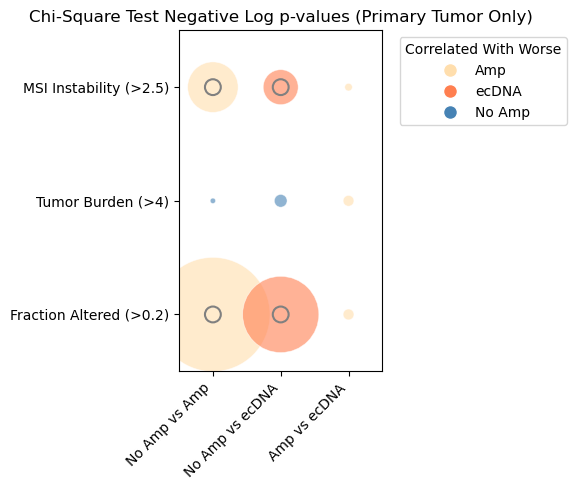

In [46]:
## Plot bubble plot for primary tumors ##

# Scale the bubbles
scale = 100

primary_results['Bubble Size'] = -np.log10(primary_results['P-value']) * scale  # Adjust multiplier for better visibility
color_map = {'Amp': colors[1], 'ecDNA': colors[2], 'No Amp': colors[0]}
fig, ax = plt.subplots(figsize=(6, 5))

scatter = plt.scatter(primary_results['Comparison'], primary_results['Category'], s=primary_results['Bubble Size'], alpha=0.6, 
    c=primary_results['More Correlated with High'].map(color_map), edgecolors='w', linewidth=0.5)

# Add rings to highlight significance
highlight = primary_results[primary_results['P-value'] < 0.05]
ax.scatter(highlight['Comparison'], highlight['Category'], s=-np.log10(0.05) * scale, facecolors='none', edgecolors='grey', linewidth=1.5)

# Add custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_map.items()]
ax.legend(handles=handles, title='Correlated With Worse', bbox_to_anchor=(1.05, 1), loc='upper left')


ax.set_xticklabels(primary_results['Comparison'], rotation=45, ha='right')
custom_y_labels = [f'Fraction Altered (>{cutoffs[1]})', f'Tumor Burden (>{cutoffs[0]})', f'MSI Instability (>{cutoffs[2]})']
ax.set_yticks(list(primary_results['Category'].unique()))
ax.set_yticklabels(custom_y_labels)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Chi-Square Test Negative Log p-values (Primary Tumor Only)')

# Spacing adjustments
ax.set_xlim([-0.5, len(primary_results['Comparison'].unique()) - 0.5])
ax.set_ylim([-0.5, len(custom_y_labels) - 0.5])
plt.tight_layout()


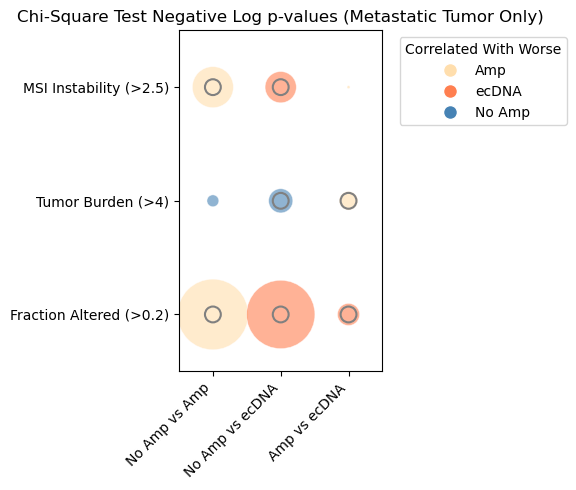

In [47]:
## Plot bubble plot for primary tumors ##

scale = 100
met_results['Bubble Size'] = -np.log10(met_results['P-value']) * scale  # Adjust multiplier for better visibility

color_map = {'Amp': colors[1], 'ecDNA': colors[2], 'No Amp': colors[0]}
fig, ax = plt.subplots(figsize=(6, 5))
scatter = plt.scatter(met_results['Comparison'], met_results['Category'], s=met_results['Bubble Size'], alpha=0.6, c=met_results['More Correlated with High'].map(color_map), edgecolors='w', linewidth=0.5)

# Highlight significance
highlight = met_results[met_results['P-value'] < 0.05]
ax.scatter(highlight['Comparison'], highlight['Category'], s=-np.log10(0.05) * scale, facecolors='none', edgecolors='grey', linewidth=1.5) 

# Add custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_map.items()]
ax.legend(handles=handles, title='Correlated With Worse', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xticklabels(met_results['Comparison'], rotation=45, ha='right')
custom_y_labels = [f'Fraction Altered (>{cutoffs[1]})', f'Tumor Burden (>{cutoffs[0]})', f'MSI Instability (>{cutoffs[2]})']
ax.set_yticks(list(met_results['Category'].unique()))
ax.set_yticklabels(custom_y_labels)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Chi-Square Test Negative Log p-values (Metastatic Tumor Only)')

# Adjust spacing
ax.set_xlim([-0.5, len(met_results['Comparison'].unique()) - 0.5])
ax.set_ylim([-0.5, len(custom_y_labels) - 0.5])
plt.tight_layout()


Text(0.5, 0, 'Age')

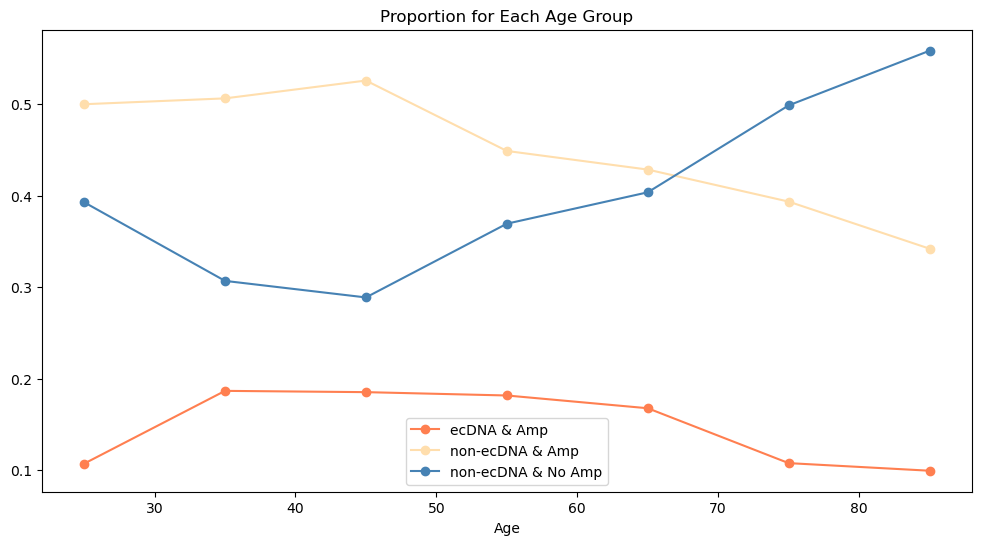

In [48]:
## Plot ecDNA over age ## 

# Calculate proportions of ecDNA and non-ecDNA for each age
echo_combined = ecDNA_patient[ecDNA_patient['combined_status'] != 'NA']
bins = np.arange(0, 101, 10)
bin_labels = [bins[i] + 5 for i in range(len(bins)-1)]

# Group ages into bins with labels
echo_combined['Age_bin'] = pd.cut(echo_combined['deIDAge'], bins=bins, labels=bin_labels, right=False)

age_counts = echo_combined.groupby(['Age_bin', 'combined_status']).size().unstack(fill_value=0)
age_counts['total'] = age_counts.sum(axis=1)
age_counts['ecDNA_prop'] = age_counts['ecDNA & Amp'] / age_counts['total']
age_counts['non_ecDNA_Amp_prop'] = age_counts['non-ecDNA & Amp'] / age_counts['total']
age_counts['non_ecDNA_Non_Amp_prop'] = age_counts['non-ecDNA & No Amp'] / age_counts['total']

plt.figure(figsize=(12,6))
plt.plot(age_counts.index, age_counts['ecDNA_prop'], marker='o', linestyle='-', color=colors[2], label='ecDNA & Amp')
plt.plot(age_counts.index, age_counts['non_ecDNA_Amp_prop'], marker='o', linestyle='-', color=colors[1], label='non-ecDNA & Amp')
plt.plot(age_counts.index, age_counts['non_ecDNA_Non_Amp_prop'], marker='o', linestyle='-', color=colors[0], label='non-ecDNA & No Amp')
plt.legend()
plt.title("Proportion for Each Age Group")
plt.xlabel("Age")

In [49]:
## ecDNA and stage of cancer ##

crosstab_cancerType = pd.crosstab(echo_sample['combined'], echo_sample['stageHighest'], normalize = 'index')
crosstab_cancerType

stageHighest,Stage 1-3,Stage 4,Unknown
combined,,,
NA,0.522581,0.154839,0.322581
No ecDNA & Amp,0.622512,0.185323,0.192164
No ecDNA & No Amp,0.691500,0.152049,0.156451
ecDNA & Amp,0.602344,0.220920,0.176736


In [50]:
## ecDNA and primary/met ##

crosstab_cancerType = pd.crosstab(echo_sample['combined'], echo_sample['sampleType'], normalize = 'index')
crosstab_cancerType

sampleType,Local Recurrence,Metastasis,Primary,Unknown
combined,,,,
NA,0.000000,0.658065,0.309677,0.032258
No ecDNA & Amp,0.008085,0.564988,0.414179,0.012749
No ecDNA & No Amp,0.008466,0.475449,0.506603,0.009482
ecDNA & Amp,0.008115,0.543733,0.431921,0.016231


In [51]:
## Co-occurence of ecDNA ##

# tracks which samples have what ecDNA positives
ecDNA_by_sample = {}

# indexes into a matrix, reverse
ecDNA_indexes = {}
# to track counts of ecDNA total for percentages
ecDNA_counts = {}
# tracker for index
ecDNA_index_curr = 0
for i, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if not row['gene'] in ecDNA_indexes :
            ecDNA_indexes[row['gene']] = ecDNA_index_curr
            ecDNA_index_curr += 1
            ecDNA_counts[row['gene']] = 1
        else :
            ecDNA_counts[row['gene']] += 1
reverse_ecDNA_indexes = {value: key for key, value in ecDNA_indexes.items()}


# co-occurence matrix
ecDNA_matrix = [[0 for _ in range(len(ecDNA_counts))] for _ in range(len(ecDNA_counts))]

for i, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if not row['tumorSampleId'] in ecDNA_by_sample :
            ecDNA_by_sample[row['tumorSampleId']] = set()
        for gene in ecDNA_by_sample[row['tumorSampleId']] :
            ecDNA_matrix[ecDNA_indexes[row['gene']]][ecDNA_indexes[gene]] += 1
            ecDNA_matrix[ecDNA_indexes[gene]][ecDNA_indexes[row['gene']]] += 1

        ecDNA_by_sample[row['tumorSampleId']].add(row['gene'])

# Calculate jaccard indexes for colors
ecDNA_matrix_jaccard = copy.deepcopy(ecDNA_matrix)
for row in range(len(ecDNA_counts)) :
    for col in range(len(ecDNA_counts)) :
        ecDNA_matrix_jaccard[row][col] = ecDNA_matrix_jaccard[row][col] / (ecDNA_counts[reverse_ecDNA_indexes[row]] + ecDNA_counts[reverse_ecDNA_indexes[col]] - ecDNA_matrix_jaccard[row][col])
        if row == col :
            ecDNA_matrix_jaccard[row][col] = 0
            ecDNA_matrix[row][col] = 0

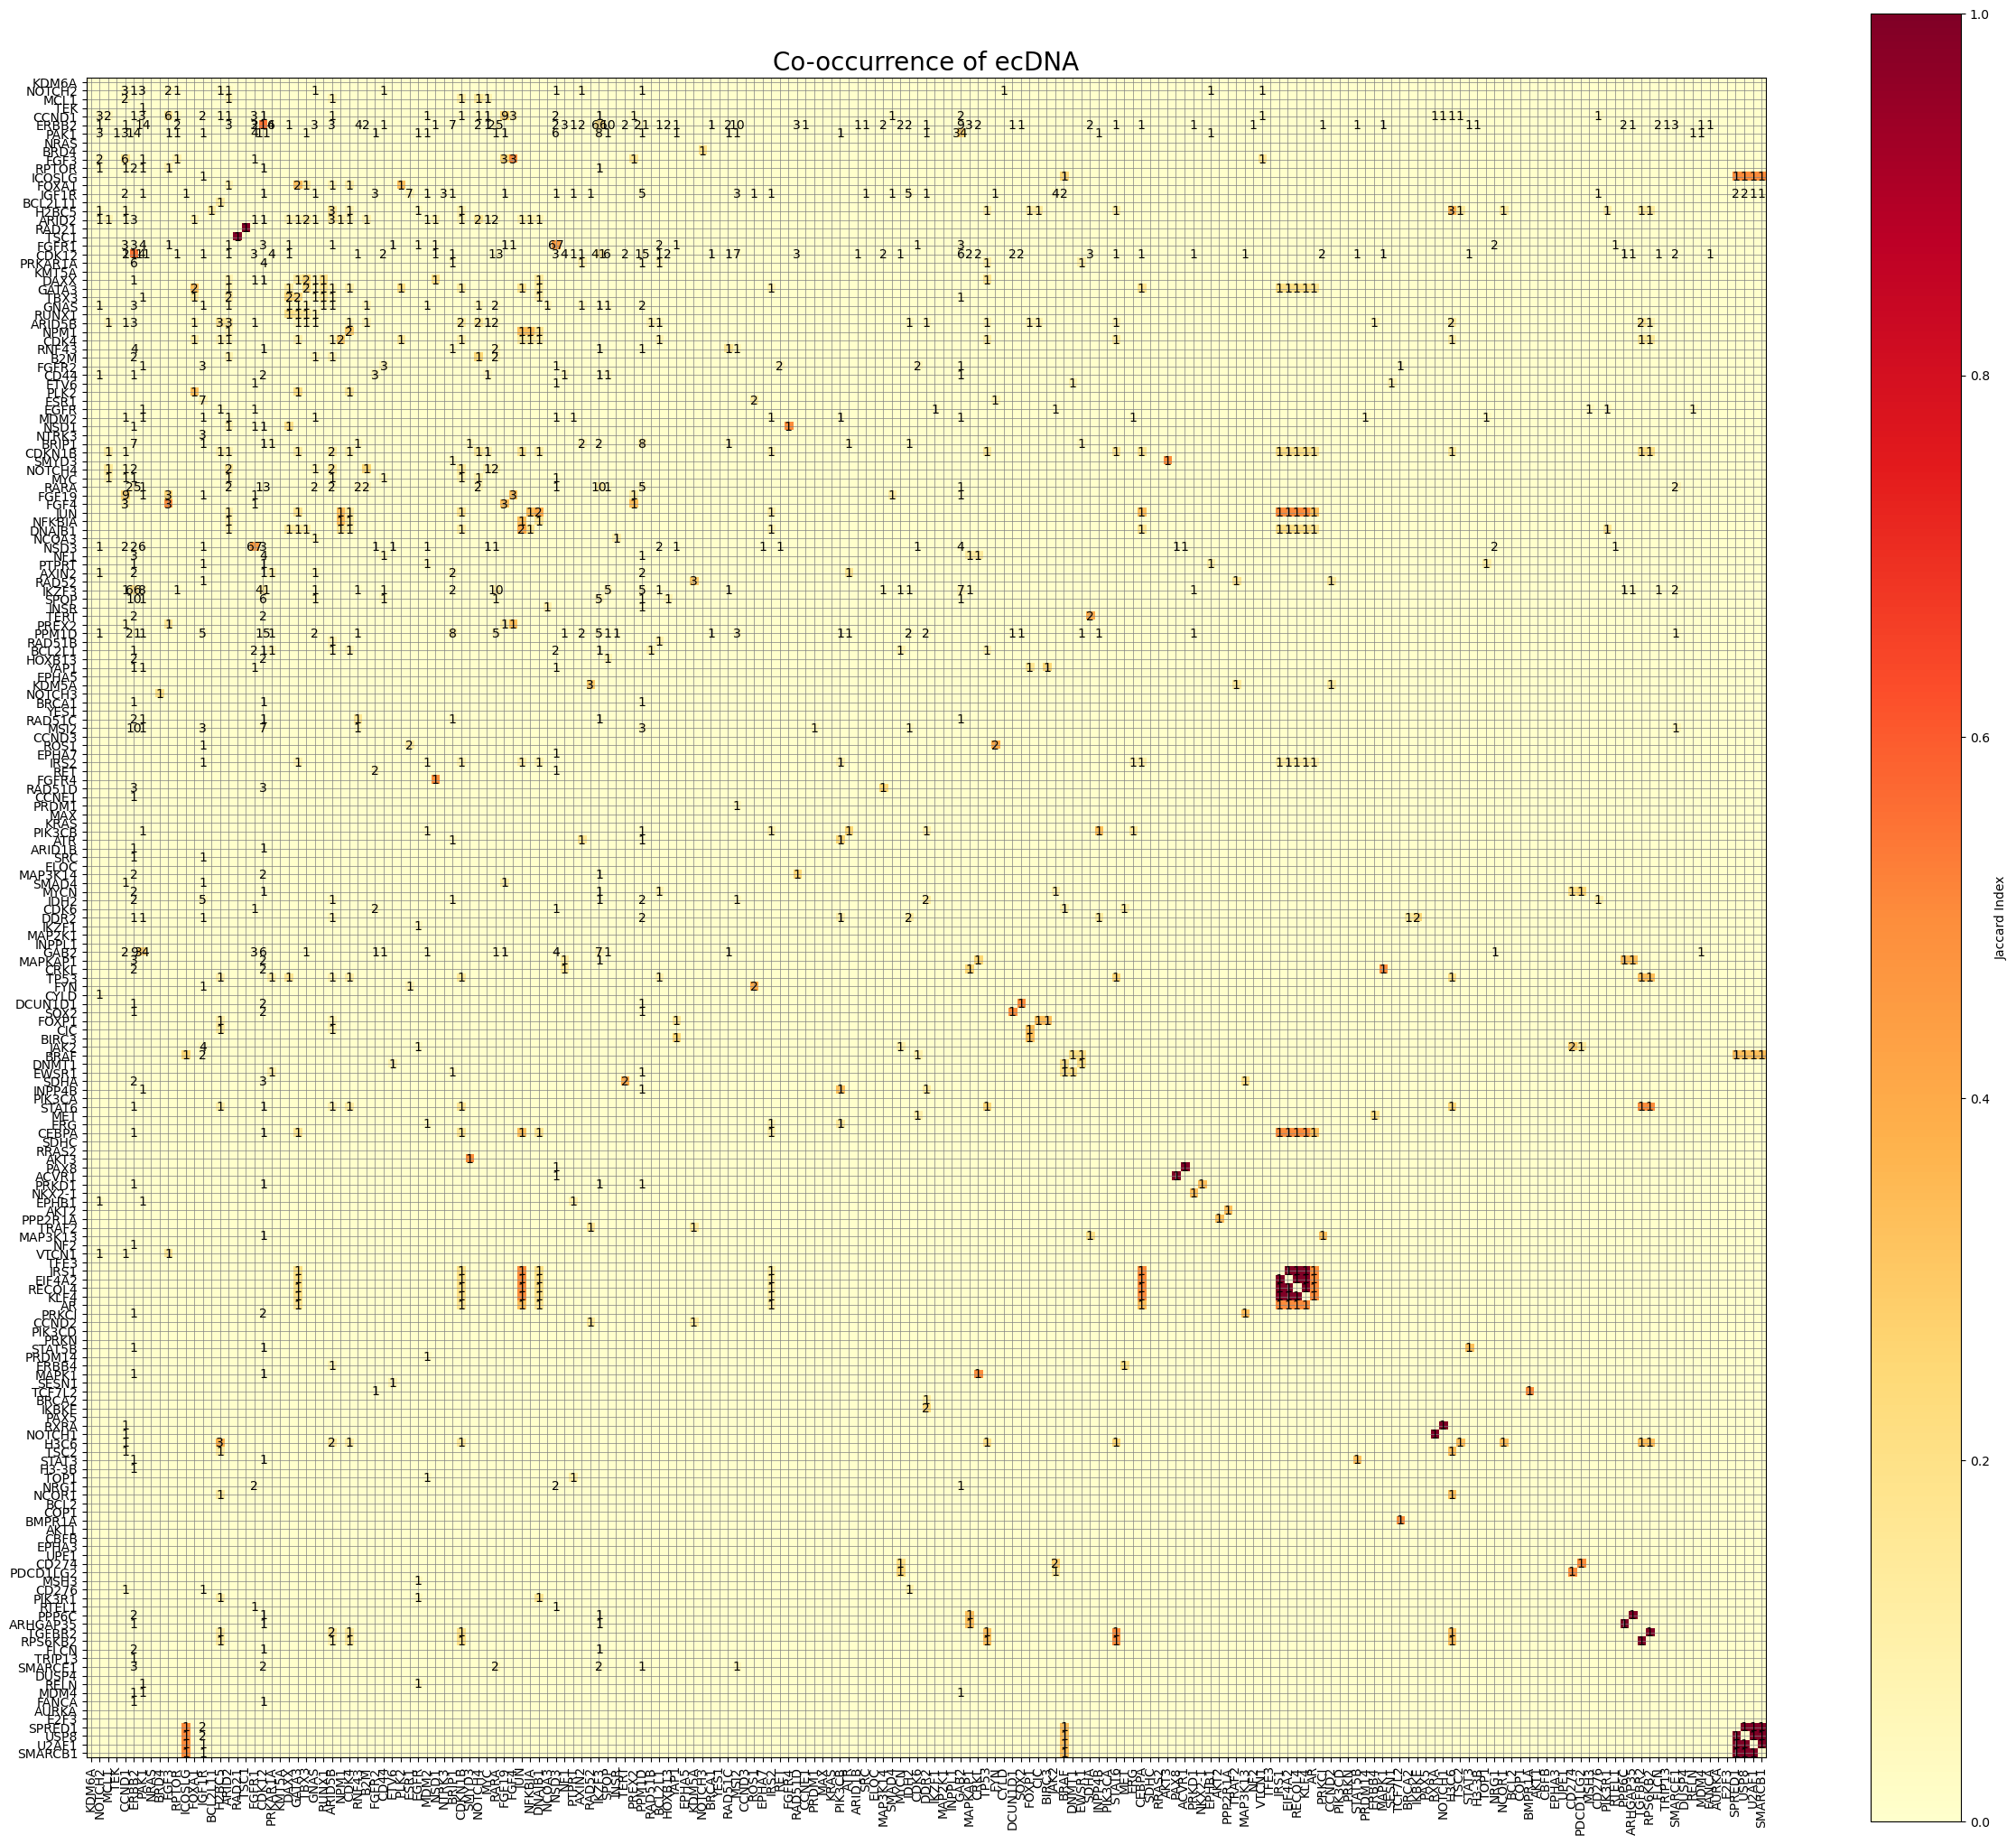

In [52]:
## Plot all genes ##

plt.figure(figsize=(30,26))
plt.grid(True, which='both', color='grey', linewidth=0.5)

plt.imshow(ecDNA_matrix_jaccard, cmap='YlOrRd', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Jaccard Index')
ticks = np.arange(len(reverse_ecDNA_indexes))
plt.xticks(ticks, [reverse_ecDNA_indexes[i] for i in range(len(reverse_ecDNA_indexes))], rotation=90)
plt.yticks(ticks, [reverse_ecDNA_indexes[i] for i in range(len(reverse_ecDNA_indexes))])

# Add labels
for i in range(len(reverse_ecDNA_indexes)):
    for j in range(len(reverse_ecDNA_indexes)):
        if ecDNA_matrix[i][j] != 0:
            plt.text(j, i, f"{ecDNA_matrix[i][j]}", ha='center', va='center', color='black')
plt.title("Co-occurrence of ecDNA", size = 20)
plt.show()

Text(0.5, 1.0, 'Co-occurrence of ecDNA (Most Common Genes)')

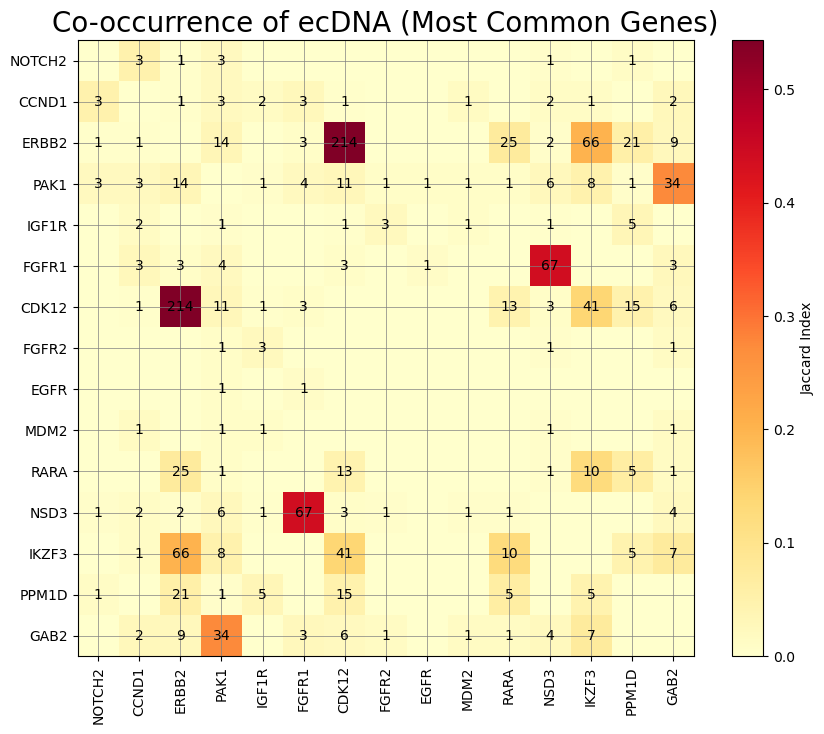

In [53]:
## Only look at top 15 genes ##

# The genes to keep
keep = [ecDNA_indexes[i] for i in list(gene_ecDNA_top15.keys())]
keep.sort()
dontkeep = [num for num in range(len(ecDNA_matrix_jaccard)) if num not in keep]
matrix_small = np.delete(ecDNA_matrix_jaccard, dontkeep, axis=0)
matrix_small = np.delete(matrix_small, dontkeep, axis=1)

plt.figure(figsize=(10,8))
plt.grid(True, which='both', color='grey', linewidth=0.5)

plt.imshow(matrix_small, cmap='YlOrRd', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Jaccard Index')
ticks = np.arange(len(keep))
plt.xticks(ticks, [reverse_ecDNA_indexes[i] for i in keep], rotation=90)
plt.yticks(ticks, [reverse_ecDNA_indexes[i] for i in keep])

# Add labels
for i in range(len(keep)):
    for j in range(len(keep)):
        if ecDNA_matrix[keep[i]][keep[j]] != 0:
            plt.text(j, i, f"{ecDNA_matrix[keep[i]][keep[j]]}", ha='center', va='center', color='black')
            
plt.title("Co-occurrence of ecDNA (Most Common Genes)", size = 20)

### Timeline

In [54]:
## Set up the data from CDSI ##

timeline_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_timeline_follow_up.txt', sep = '\t')
sequencing = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_specimen_surgery.txt', sep = '\t')

sequencing_dict = {}
for i, row in sequencing.iterrows() :
    sequencing_dict[row['SAMPLE_ID']] = row['START_DATE']

# Dictionaries for time of last contact and death
last_contact_dict = {}
death_dict = {}
for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Last Contact" :
        last_contact_dict[row['PATIENT_ID']] = row['START_DATE']
    if row['SOURCE'] == "Patient Deceased" :
        death_dict[row['PATIENT_ID']] = row['START_DATE']

# To store all the info
timelines = {}

echo_sample_nona = echo_sample[echo_sample['combined'] != 'NA']
echo_sample_nona['patientId'] = ''
for i, row in echo_sample_nona.iterrows() :
    echo_sample_nona.loc[i, 'patientId'] = row['sampleId'].split('-')[0] + '-' + row['sampleId'].split('-')[1]

# To keep track of start point
earliest_date = {}
for i, row in echo_sample_nona.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if row['sampleId'] in sequencing_dict :
            if not row['patientId'] in timelines :
                timelines[row['patientId']] = []
                earliest_date[row['patientId']] = sequencing_dict[row['sampleId']]
            else :
                earliest_date[row['patientId']] = min(earliest_date[row['patientId']], sequencing_dict[row['sampleId']])

# Dictionary matching sampleId to ecDNA status
sample_to_ecDNA = {}
for i, row in echo_sample_nona.iterrows() :
    if row['patientId'] in timelines :
        sample_to_ecDNA[row['sampleId']] = row['combined']
    

In [55]:
## Add other timepoints ##

for sample in sample_to_ecDNA :
    patientId = sample.split('-')[0] + '-' + sample.split('-')[1]
    try :
        if (sequencing_dict[sample] - earliest_date[patientId]) != 0 :        
            timelines[patientId].append((sequencing_dict[sample] - earliest_date[patientId], sample_to_ecDNA[sample]))
    except :
        _ = 5
timelines_interesting = {key: value for key, value in timelines.items() if value}

endpoints = []
for patientId in timelines_interesting :
    if patientId in death_dict :
        timelines[patientId].append((death_dict[patientId] - earliest_date[patientId], "Patient Deceased"))
        endpoints.append(death_dict[patientId] - earliest_date[patientId])
    elif patientId in last_contact_dict :
        timelines[patientId].append((last_contact_dict[patientId] - earliest_date[patientId], "Last Contact"))
        endpoints.append(last_contact_dict[patientId] - earliest_date[patientId])
    # Not found, skipping patient
    else :
        timelines[patientId] = []

timelines_interesting = {key: value for key, value in timelines.items() if value}
        

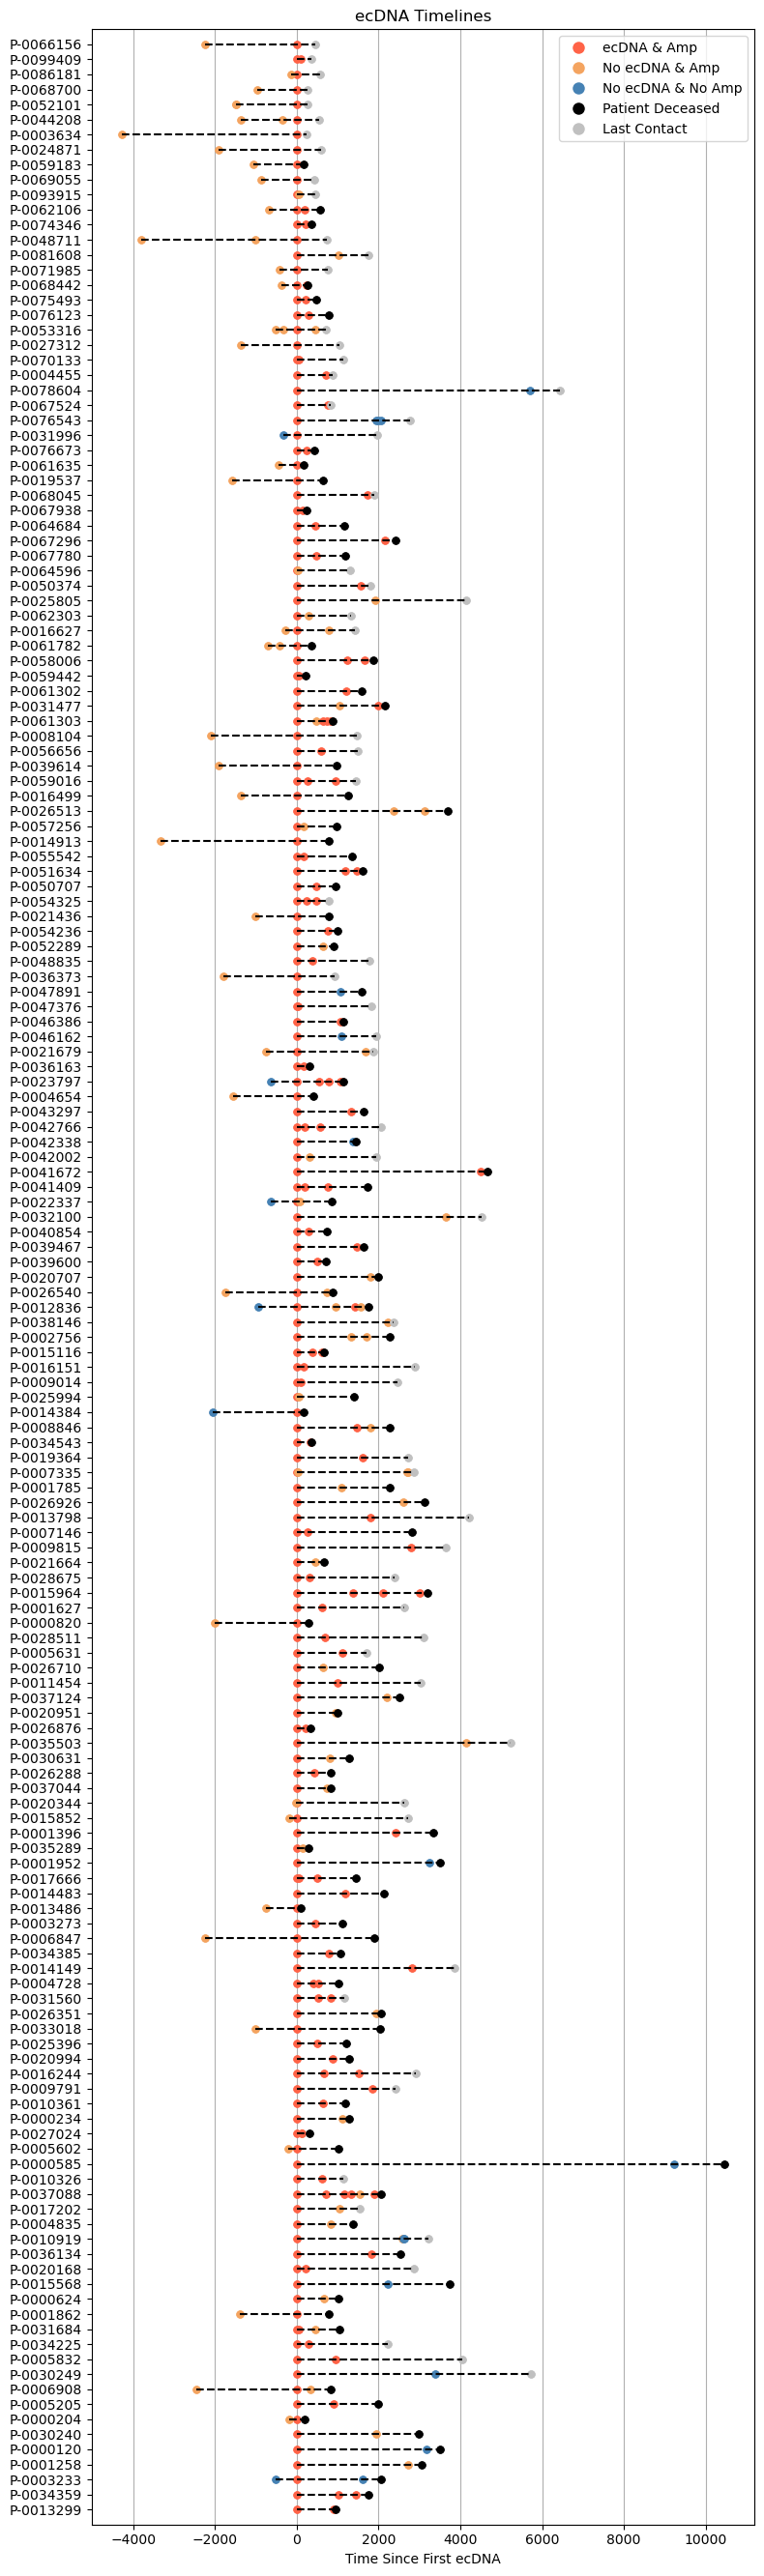

In [56]:
## Plot timeline ##

for i in timelines_interesting :
    timelines_interesting[i].insert(0, (0, 'ecDNA & Amp'))

startpoints = []
for patientId in timelines_interesting :
    earliest = 10000000
    for pair in timelines_interesting[patientId] :
        earliest = min(earliest, pair[0])
    startpoints.append(earliest)
    
# Plotting the timelines
plt.figure(figsize=(8, 2 + 0.15 * (len(timelines_interesting))))  # Adjust figsize as needed

label_colors = {
    'ecDNA & Amp': 'tomato',
    'No ecDNA & Amp': 'sandybrown',
    'No ecDNA & No Amp': 'steelblue',
    'Patient Deceased': 'black',
    'Last Contact': 'silver',
}

for idx, (label, points) in enumerate(timelines_interesting.items(), start=1):
    # Extract x values (times) and labels
    times, labels = zip(*points)
    
    # Plot lines connecting points with label-specific color
    for i in range(len(times)):
            plt.plot([times[i], times[i]], [idx, idx], '.-', color=label_colors[labels[i]], markersize=10,linewidth=2)
    plt.hlines(y=idx, xmin=startpoints[idx-1], xmax=endpoints[idx-1], color='black', linestyle='--')

# Customize plot appearance
plt.ylim(0, len(timelines_interesting) + 1)  # Set y-axis limit to accommodate all timelines
plt.xlabel('Time Since First ecDNA')
plt.yticks(np.arange(1, len(timelines_interesting) + 1), timelines_interesting.keys())
plt.title(f'ecDNA Timelines')

# Add legend with colored markers
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
                  for label, color in label_colors.items()]
plt.legend(handles=legend_handles, loc='upper right')

plt.grid(axis='x')
plt.tight_layout()

# Show plot
plt.show()